In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd

#저장라이브러리
import pickle

import gc

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SelectFromModel
# from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# from xgboost import XGBClassifier
# from sklearn.metrics import classification_report
from catboost import CatBoostClassifier

# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

import gc


In [ ]:
# import matplotlib.pyplot as plt

# # 그래프 기본 설정
# plt.rcParams['figure.figsize'] = 12, 6
# plt.rcParams['font.size'] = 14
# plt.rcParams['axes.unicode_minus'] = False


# import matplotlib as mpl
# import matplotlib.font_manager as fm

# # 폰트 파일 경로 지정
# font_path = '/content/drive/MyDrive/Colab Notebooks/NanumGothic.ttf'

# # 폰트 등록 및 matplotlib 설정
# font_name = fm.FontProperties(fname=font_path).get_name()
# fm.fontManager.addfont(font_path)
# mpl.rc('font', family=font_name)

# 1. data load

In [2]:
train = pd.read_parquet('train_잔액정보.parquet')

In [3]:
seg = pd.read_parquet('train_segment.parquet')

# 2. data split

In [4]:
# 타겟 변수 분리
X = train
y = seg['Segment'] # segment만

# 샘플링(240만건은 너무 많 => 7월 40만)
X_sample = X.iloc[:400000]
y_sample = y.iloc[:400000]

# ID 제거
id_sample = X_sample['ID']
X_sample = X_sample.drop('ID', axis=1)

# train/val 분리
X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=40)

In [5]:
len(X_train), len(X_val)

(320000, 80000)

# 3. select feature

- catboost

In [6]:
cat_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    eval_metric='MultiClass', # eval_metric을 단일 값 평가지표로 변경
    custom_metric='F1', # F1을 custom_metric으로 추가
    random_state=40,
    verbose=False
)

In [8]:
cat_model.fit(X_train, y_train)

---
# 4. feature importance
- **get feature importances**
  - 학습된 모델에서 변수의 중요도 추출

In [9]:
# 변수 중요도 추출
feature_importances = cat_model.get_feature_importance(prettified=True)
print(feature_importances.head())

     Feature Id  Importances
0     평잔_일시불_6M    16.652857
1         평잔_6M    15.130343
2    잔액_일시불_B0M     7.386742
3      평잔_CA_6M     6.835071
4  월중평잔_일시불_B0M     6.554192


- **visualize feature importances**
   - 어떤 변수가 모델에 가장 큰 영향을 미치는지 파악

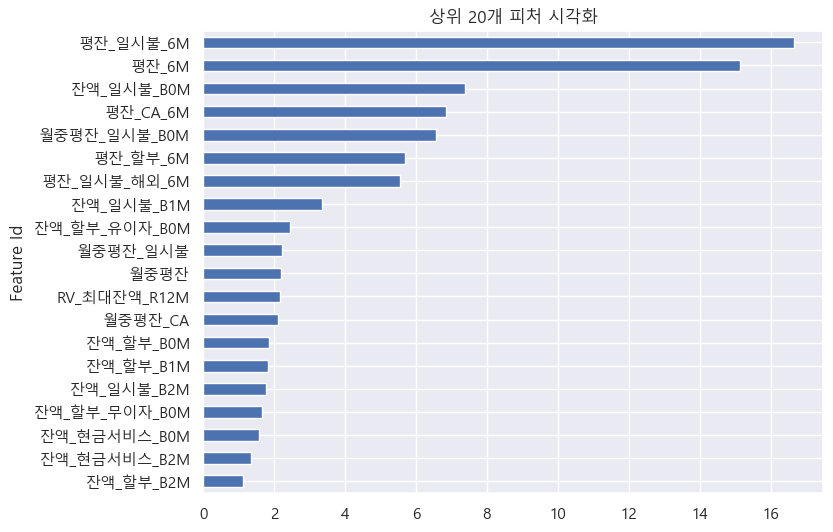

In [11]:
import matplotlib.pyplot as plt

# 상위 20개 시각화
top_n = 20
feature_importances[:top_n].plot(
    kind='barh',
    x='Feature Id',
    y='Importances',
    figsize=(8, 6),
    legend=False
)
plt.title(f"상위 20개 피처 시각화")
plt.gca().invert_yaxis()
plt.show()

- **select features**
  - 계산된 중요도를 기반으로 가장 중요한 특성들을 선택하는 방법 결정
  - ex) 중요도 상위 N개, 특정 임계값 이상의 중요도를 가진 특성



In [12]:
# 상위 15개 피처
top_n = 15
selected_features = feature_importances['Feature Id'][:top_n].tolist()

print("선택된 피처 수:", len(selected_features))
print("선택된 피처 이름:", selected_features)

선택된 피처 수: 15
선택된 피처 이름: ['평잔_일시불_6M', '평잔_6M', '잔액_일시불_B0M', '평잔_CA_6M', '월중평잔_일시불_B0M', '평잔_할부_6M', '평잔_일시불_해외_6M', '잔액_일시불_B1M', '잔액_할부_유이자_B0M', '월중평잔_일시불', '월중평잔', 'RV_최대잔액_R12M', '월중평잔_CA', '잔액_할부_B0M', '잔액_할부_B1M']


- data store
    - train

In [14]:
columns_to_select = ['ID'] + selected_features
train_selected_with_id = train[columns_to_select]

train_selected_with_id.head()

,ID,평잔_일시불_6M,평잔_6M,잔액_일시불_B0M,평잔_CA_6M,월중평잔_일시불_B0M,평잔_할부_6M,평잔_일시불_해외_6M,잔액_일시불_B1M,잔액_할부_유이자_B0M,월중평잔_일시불,월중평잔,RV_최대잔액_R12M,월중평잔_CA,잔액_할부_B0M,잔액_할부_B1M
0,TRAIN_000000,2440,15988,998,17008,1084,572,0,736,0,1503,17237,0,23468,962,640
1,TRAIN_000001,2677,7045,2565,0,4090,2736,0,6795,2390,4447,7967,0,0,2390,2779
2,TRAIN_000002,9118,66549,5312,43351,5006,4429,0,5150,0,5540,59917,5329,18572,5113,9451
3,TRAIN_000003,884,30139,730,30697,487,5097,0,462,2368,606,27854,0,28902,5025,6134
4,TRAIN_000004,21,28,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
train_selected_with_id.to_parquet('train_잔액_sel.parquet')

- test

In [19]:
test = pd.read_parquet('test_잔액정보.parquet')
columns_to_select = ['ID'] + selected_features
test_selected_with_id = test[columns_to_select]
test_selected_with_id.head()

,ID,평잔_일시불_6M,평잔_6M,잔액_일시불_B0M,평잔_CA_6M,월중평잔_일시불_B0M,평잔_할부_6M,평잔_일시불_해외_6M,잔액_일시불_B1M,잔액_할부_유이자_B0M,월중평잔_일시불,월중평잔,RV_최대잔액_R12M,월중평잔_CA,잔액_할부_B0M,잔액_할부_B1M
0,TEST_00000,2933,3847,4802,0,6412,0,384,2277,0,5187,5543,0,0,0,0
1,TEST_00001,657,42634,1201,1530,1010,7979,0,1467,3120,865,57180,0,3179,8628,7985
2,TEST_00002,6253,22936,3046,0,4407,12329,0,2496,2853,5591,20641,0,0,6144,7805
3,TEST_00003,819,1206,768,0,1107,468,0,675,0,1545,2480,0,0,945,803
4,TEST_00004,979,2914,637,0,1072,2414,0,1395,0,1462,5644,0,0,2558,3888


In [20]:
test_selected_with_id.to_parquet('test_잔액_sel.parquet')